In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import pickle

import xgboost as xgb

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

plt.style.use('fivethirtyeight')

# Data Exploration

In [3]:
df = pd.read_csv('data/hotel_bookings.csv')

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [6]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


We can combine some columns with similar data together to see if it yields any better results.

In [7]:
df['total_people'] = df['adults'] + df['children'] + df['babies']
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['date'] = pd.to_datetime(df['arrival_date_year'].apply(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].apply(str))
df['room_different_from_booking'] = (df['reserved_room_type'] != df['assigned_room_type']).astype(int)

df = df.sort_values(by='date')

## `reservation_status`

In [8]:
df['reservation_status'].value_counts()

reservation_status
Check-Out    75166
Canceled     43017
No-Show       1207
Name: count, dtype: int64

In [9]:
df[df['reservation_status'] == 'Canceled'][['reservation_status', 'is_canceled']]

,reservation_status,is_canceled
74967,Canceled,1
74968,Canceled,1
74969,Canceled,1
74970,Canceled,1
74971,Canceled,1
...,...,...
13798,Canceled,1
13797,Canceled,1
13796,Canceled,1
13795,Canceled,1


We should be sure not to include the `reservation_status` column in any models, as it would leak the target data in training.

## Feature pairing

Plot the relationship between pairs of variables and the cancellation status. Looking at all pairs of variables is far too much data to compute, so we look at a small subset of some of the stronger relationships as an example.

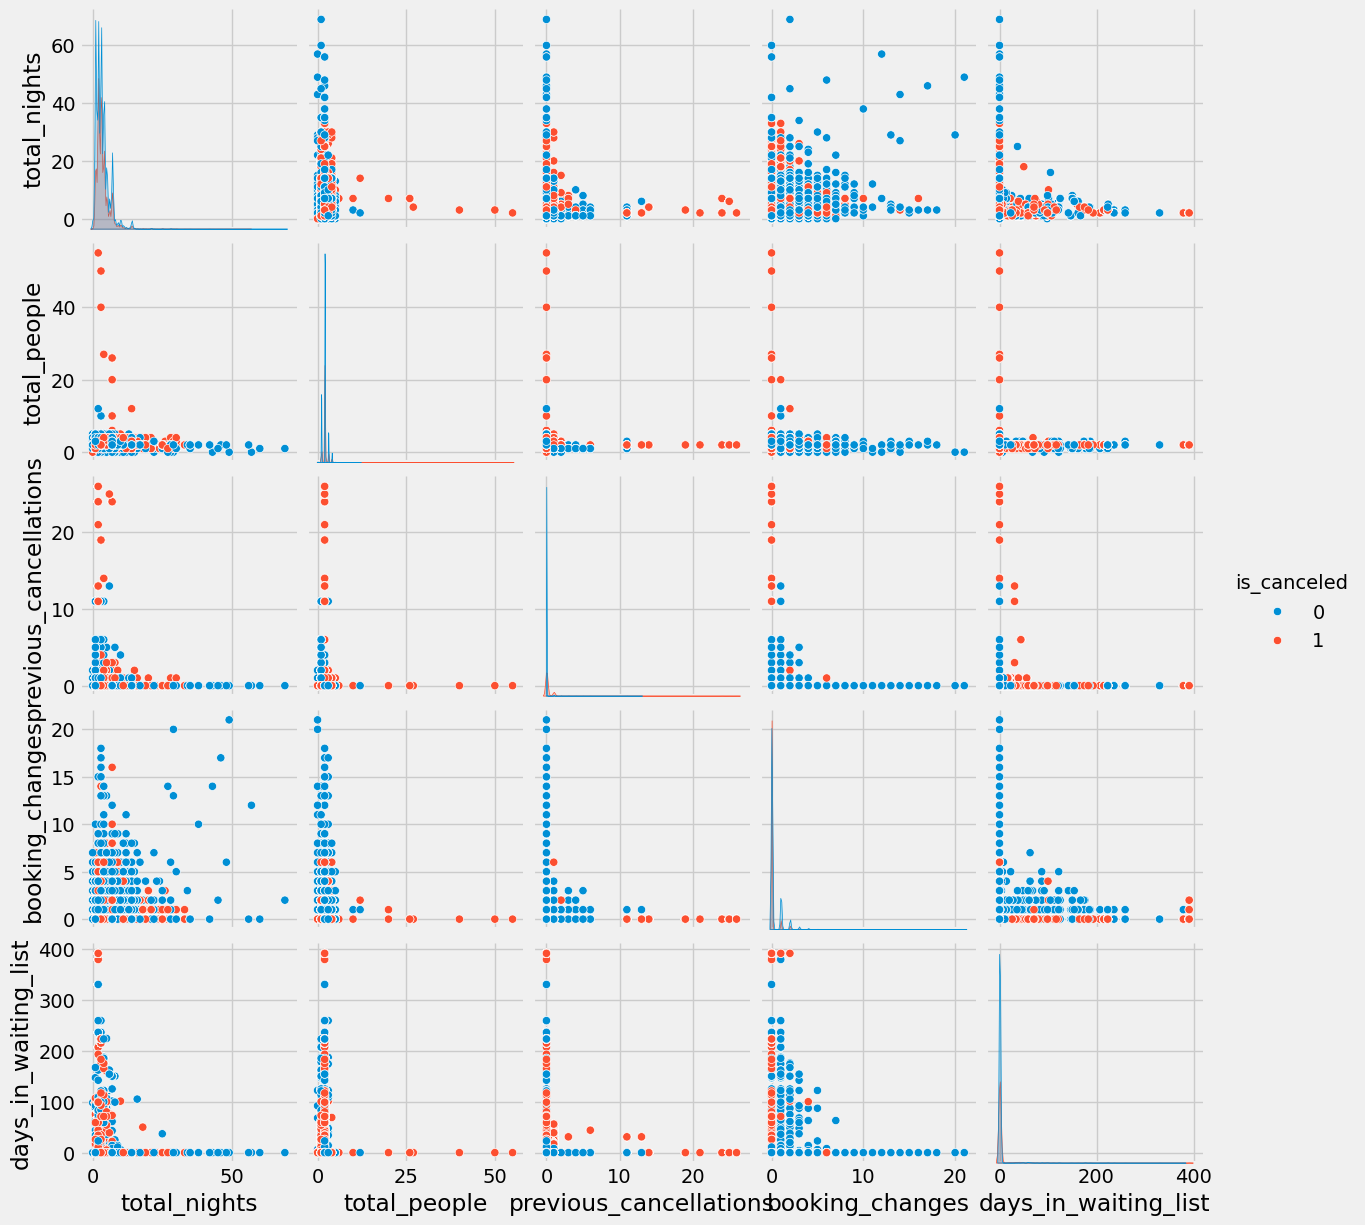

In [10]:
data_cols = ['total_nights', 'total_people', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list']
target_col = ['is_canceled']
cols = data_cols + target_col

sns.pairplot(data=df[cols], hue='is_canceled')

In particular, on its own, the `previous_cancellations` value seems to be a decent predictor of future cancellations, as it can indicate "serial cancelers."

## Cancellations over Time

We can also look at the difference in cancellations over time, using the engineered arrival date column.

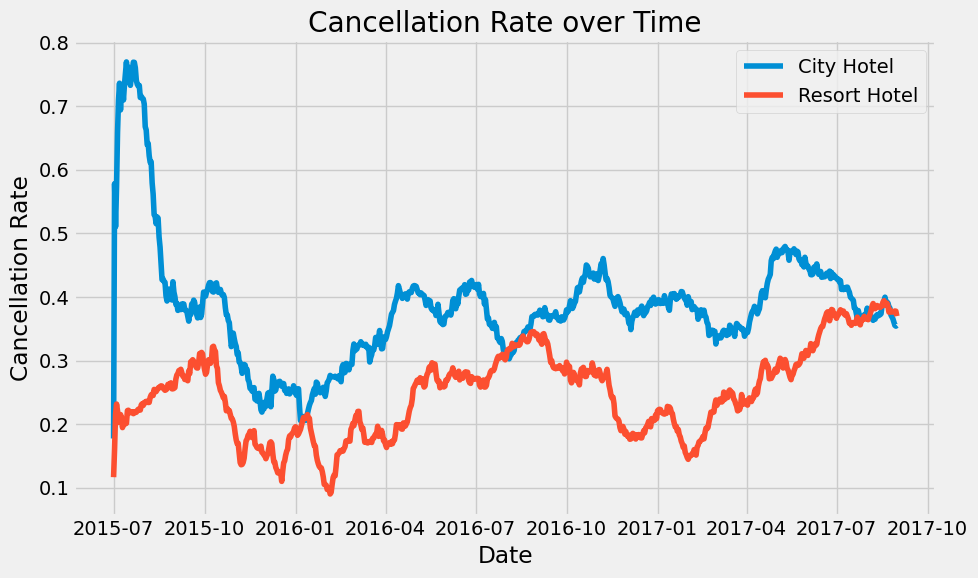

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the cancellation rate over time averaged over a 4 week window
for hotel in sorted(df['hotel'].unique()):
    ax.plot(df[df['hotel'] == hotel].groupby('date')['is_canceled'].mean().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
ax.set_xlabel('Date')
ax.set_ylabel('Cancellation Rate')
ax.legend()
plt.title('Cancellation Rate over Time')
fig.tight_layout()
fig.savefig('plots/cancel_rate_over_time.png')
plt.show()

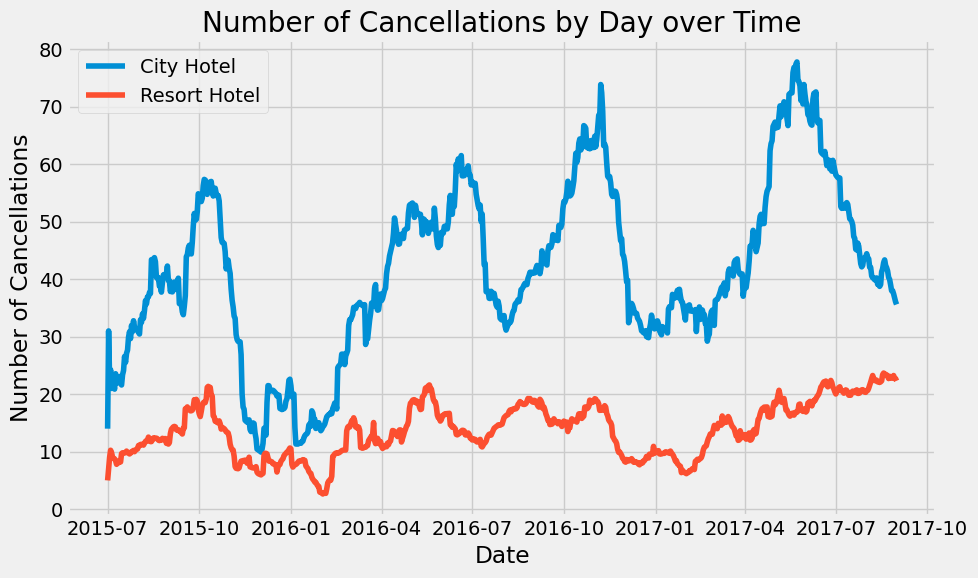

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the cancellation rate over time averaged over a 4 week window
for hotel in sorted(df['hotel'].unique()):
    ax.plot(df[df['hotel'] == hotel].groupby('date')['is_canceled'].sum().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cancellations')
ax.legend()
plt.title('Number of Cancellations by Day over Time')
fig.tight_layout()
fig.savefig('plots/cancel_number_over_time.png')
plt.show()

On average the number of cancellations for the resort hotel are lower than the number of cancellations for the city hotel. The cancellation rate for the resort hotel appears to have a slight seasonality factor, where bookings starting in the winter months were cancelled less often than those in the summer months. There doesn't seem to be as clear of a seasonality factor affecting the city hotel. Excluding the large spike in cancellations for the early months of the dataset at the city hotel, there does seem to be a slight trend upwards in the number of cancellations. Overall, the number of cancellations for the city hotel is higher, both in raw numbers and in the proportion of total bookings.

## Agent effect

In [13]:
df.groupby('agent')['is_canceled'].mean().describe()

count    333.000000
mean       0.251894
std        0.307263
min        0.000000
25%        0.000000
50%        0.125000
75%        0.400000
max        1.000000
Name: is_canceled, dtype: float64

In [14]:
total_agent_cancels = df.groupby('agent')['is_canceled'].sum().sort_values(ascending=False)
total_agent_cancels

agent
9.0      13264
240.0     5484
1.0       5280
6.0       1025
19.0       780
         ...  
469.0        0
474.0        0
475.0        0
476.0        0
535.0        0
Name: is_canceled, Length: 333, dtype: int64

In [15]:
high_cancel_rate = 0.5
agent_cancel_rates = df.groupby('agent')['is_canceled'].mean().sort_values(ascending=False)
agents_high_cancel = agent_cancel_rates[agent_cancel_rates > high_cancel_rate].index
top_30_agents_by_cancel_numbers = total_agent_cancels[agents_high_cancel].sort_values(ascending=False).head(30)
top_30_agents_by_cancel_numbers

agent
1.0      5280
19.0      780
3.0       771
37.0      717
29.0      546
21.0      506
229.0     484
20.0      359
12.0      304
134.0     299
58.0      295
56.0      256
236.0     247
44.0      232
119.0     211
86.0      197
34.0      179
68.0      165
326.0     161
31.0      154
38.0      138
154.0     136
191.0     103
208.0      95
170.0      93
248.0      83
67.0       76
41.0       75
35.0       65
281.0      53
Name: is_canceled, dtype: int64

In [17]:
def agent_inspect(agent):
    agent_mean_cancel = df[df['agent'] == agent]['is_canceled'].mean()
    agent_proportion_of_all_cancels = df[df['agent'] == agent]['is_canceled'].sum() / df['is_canceled'].sum()
    print(f'Agent {agent} cancel rate: {agent_mean_cancel}\nAgent {agent} proportion of all cancel rates: {agent_proportion_of_all_cancels}')

In [18]:
agent_inspect(1)

Agent 1 cancel rate: 0.7342511472674176
Agent 1 proportion of all cancel rates: 0.11939218523878437


In [19]:
agent_inspect(9)

Agent 9 cancel rate: 0.4150057883044961
Agent 9 proportion of all cancel rates: 0.29992764109985526


In [20]:
agent_inspect(240)

Agent 240 cancel rate: 0.39390892113202125
Agent 240 proportion of all cancel rates: 0.12400506512301013


It seems like there are some agents that have a much higher number of cancels than others. The median agent only has a 12.5% cancel rate, and the 75th percentile of cancel rates for agents is still below 50% cancel rate. Agencies 1, 9, and 240 are the most notable, as they have the highest amount of cancels by number out of all agents, and together comprise over half of all cancels.

In [21]:
df['company'].isna().sum() / len(df)

np.float64(0.943068933746545)

Although we could conduct a similar dive into the companies, almost 95% of entries don't have a company attached, so we won't go into as much detail for this column.

## Cancellation Rate by Agency over Time

In [22]:
for agency in [1, 9, 240]:
    agency_df = df[df['agent'] == agency]
    print(len(agency_df[agency_df['hotel'] == 'City Hotel']))

7137
31955
17


In [23]:
for agency in [1, 9, 240]:
    agency_df = df[df['agent'] == agency]
    print(len(agency_df[agency_df['hotel'] == 'Resort Hotel']))

54
6
13905


Agencies 1 and 9 primarily book for the city hotel, agency 240 primarily books for the resort hotel.

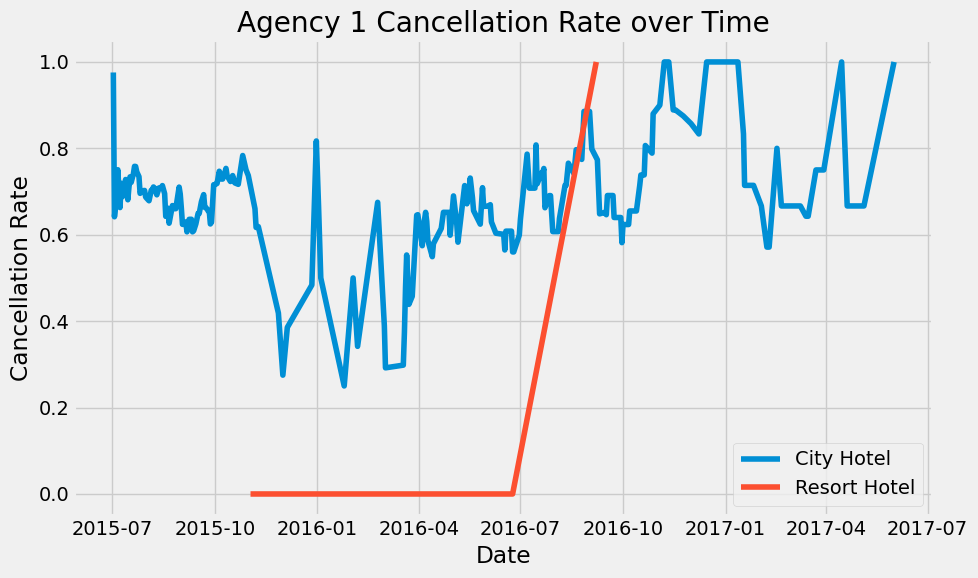

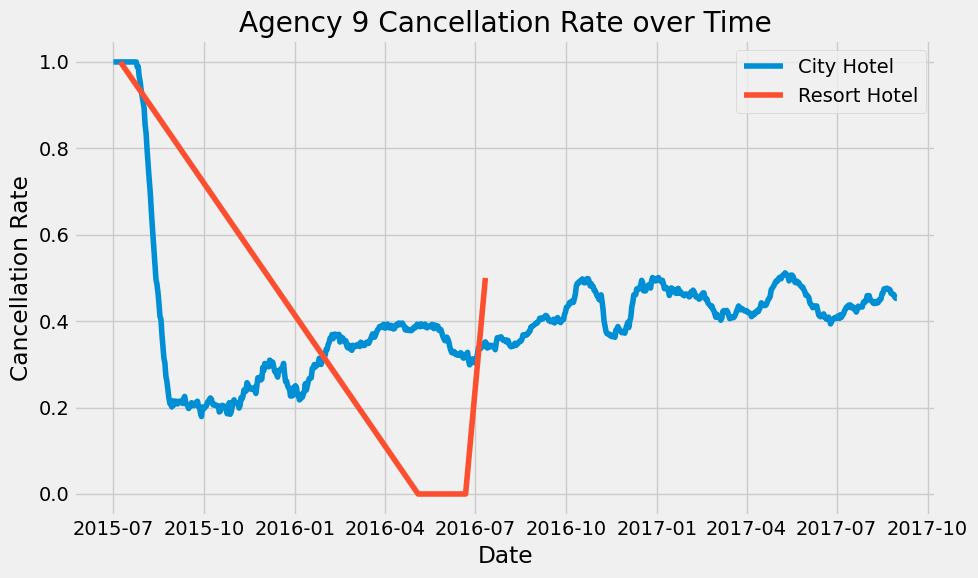

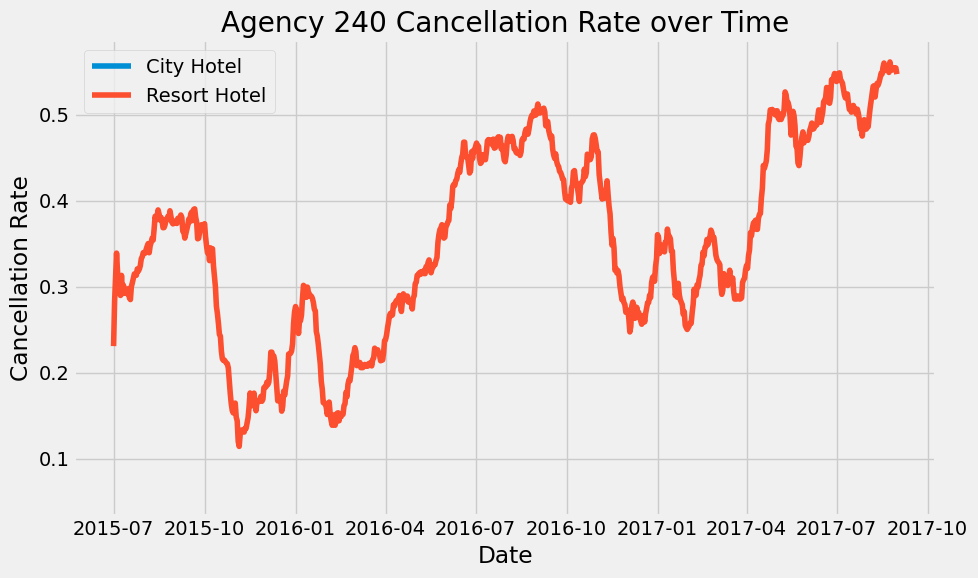

In [24]:
for agency in [1, 9, 240]:
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Plot the cancellation rate over time averaged over a 4 week window
    agency_df = df[df['agent'] == agency]
    for hotel in sorted(agency_df['hotel'].unique()):
        ax.plot(agency_df[agency_df['hotel'] == hotel].groupby('date')['is_canceled'].mean().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cancellation Rate')
    ax.legend()
    plt.title(f'Agency {agency} Cancellation Rate over Time')
    fig.tight_layout()
    fig.savefig(f'plots/agency_{agency}_cancel_rate_over_time.png')
    plt.show()

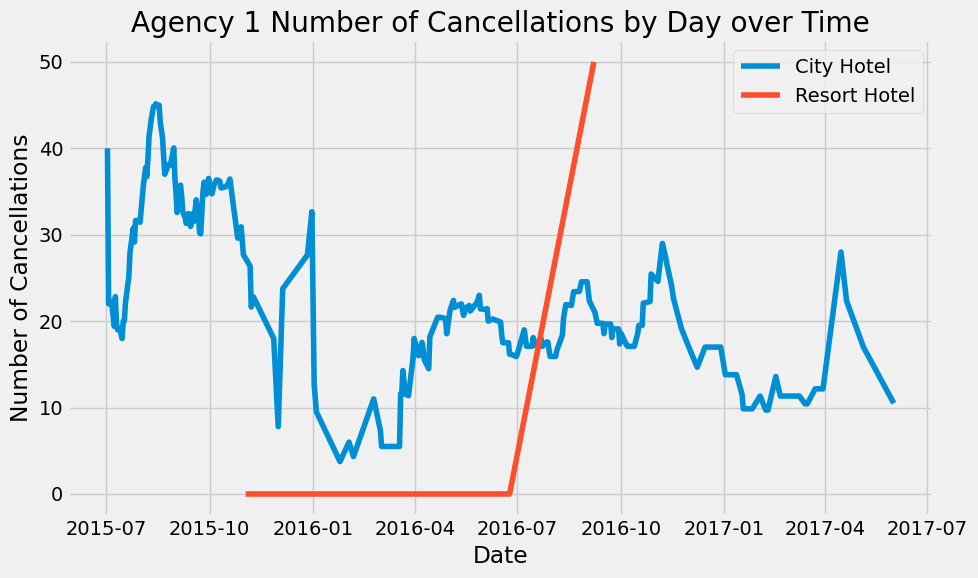

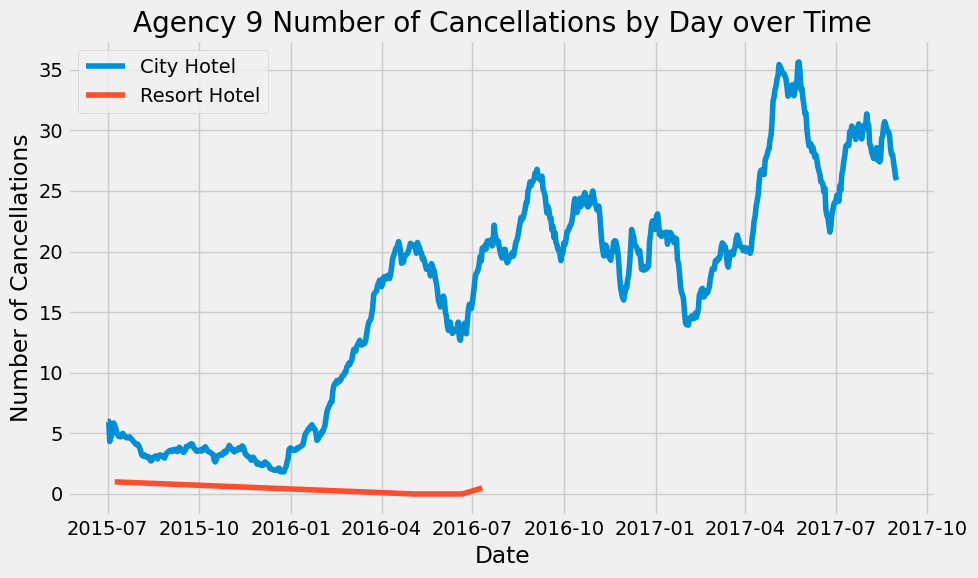

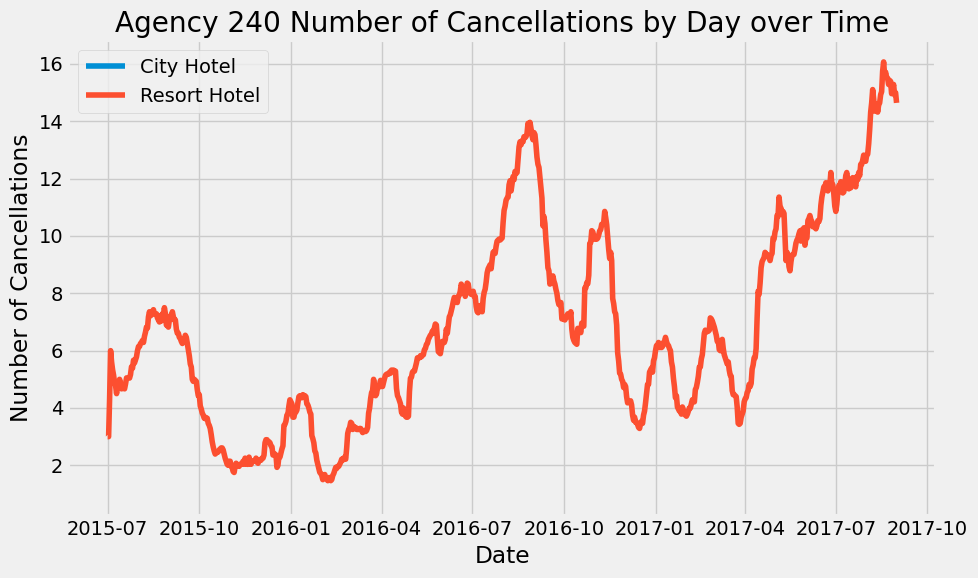

In [25]:
for agency in [1, 9, 240]:
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Plot the cancellation rate over time averaged over a 4 week window
    agency_df = df[df['agent'] == agency]
    for hotel in sorted(agency_df['hotel'].unique()):
        ax.plot(agency_df[agency_df['hotel'] == hotel].groupby('date')['is_canceled'].sum().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cancellations')
    ax.legend()
    plt.title(f'Agency {agency} Number of Cancellations by Day over Time')
    fig.tight_layout()
    fig.savefig(f'plots/agency_{agency}_cancel_number_over_time.png')
    plt.show()

The three agencies seem to primarily book for one hotel each. Although they've been booking for the entire dataset, the rate of cancellations seems to be increasing over time. However, it seems that agency 1 by raw number has been having fewer cancellations, presumably because they've been booking less. Agencies 9 and 240 do seem to be increasing in raw number of cancellations.

We can compare against other agencies with a high number of cancellations, but not the highest, to see if similar patterns appear.

In [26]:
top_30_agents_by_cancel_numbers.tail(3).index

Index([41.0, 35.0, 281.0], dtype='float64', name='agent')

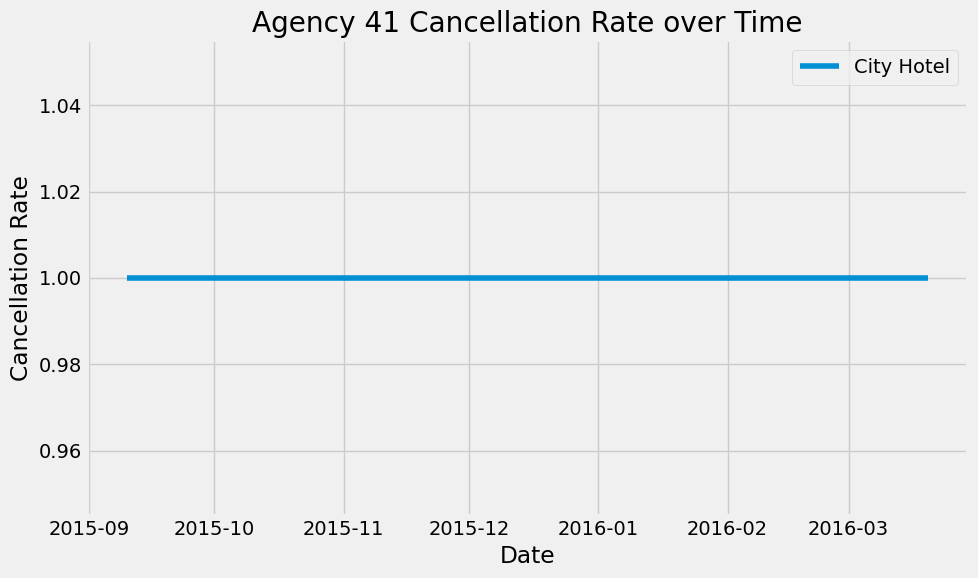

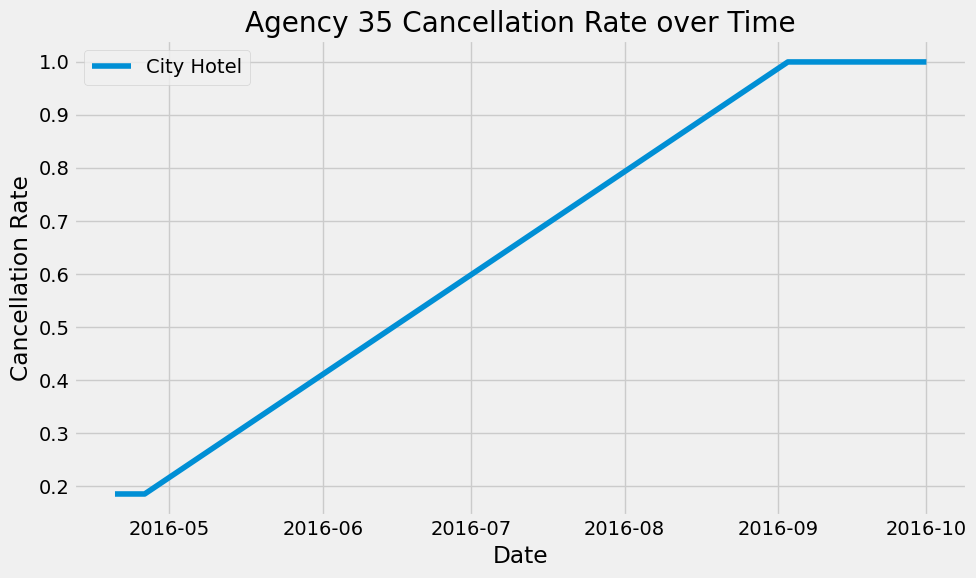

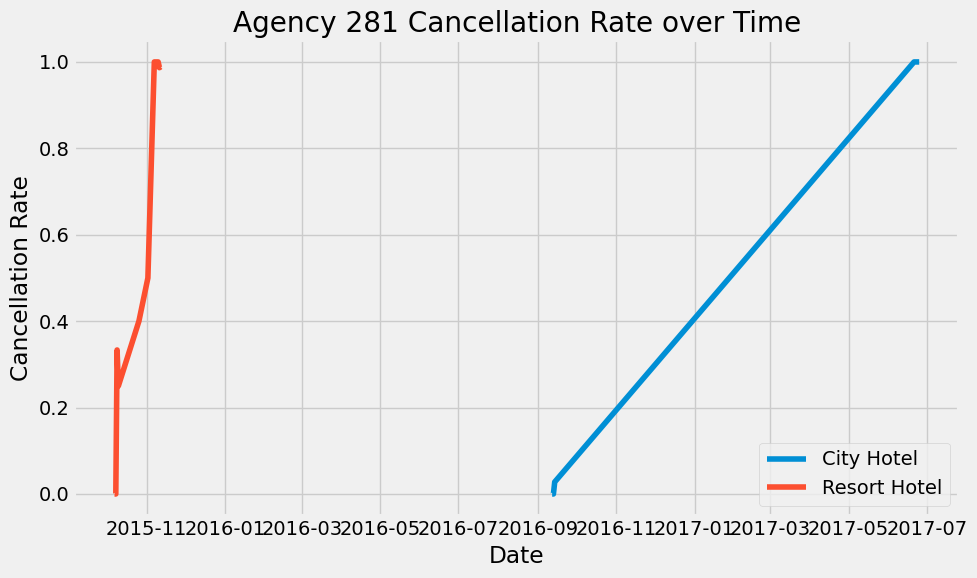

In [27]:
for agency in top_30_agents_by_cancel_numbers.tail(3).index:
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Plot the cancellation rate over time averaged over a 4 week window
    agency_df = df[df['agent'] == agency]
    for hotel in sorted(agency_df['hotel'].unique()):
        ax.plot(agency_df[agency_df['hotel'] == hotel].groupby('date')['is_canceled'].mean().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cancellation Rate')
    ax.legend()
    plt.title(f'Agency {int(agency)} Cancellation Rate over Time')
    fig.tight_layout()
    fig.savefig(f'plots/agency_{int(agency)}_cancel_rate_over_time.png')
    plt.show()

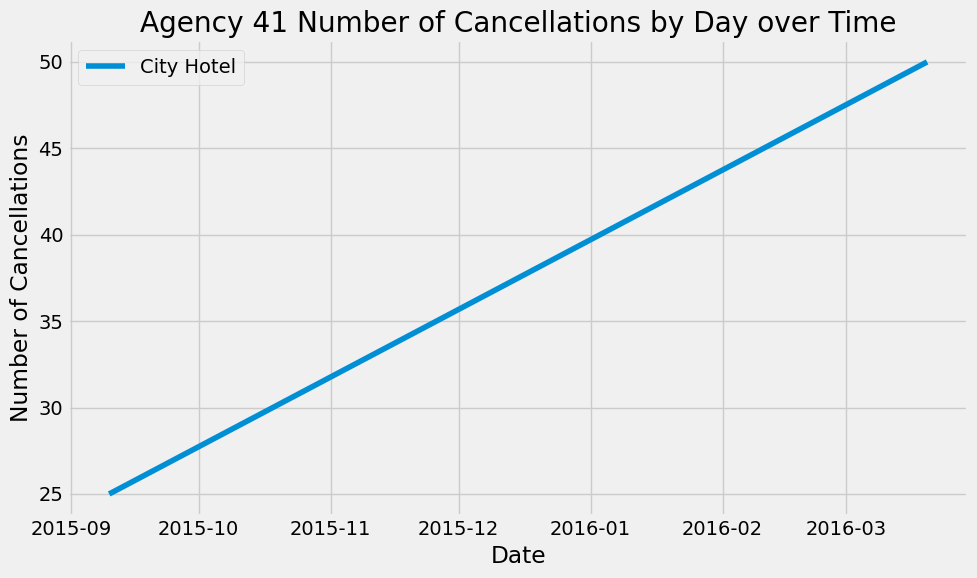

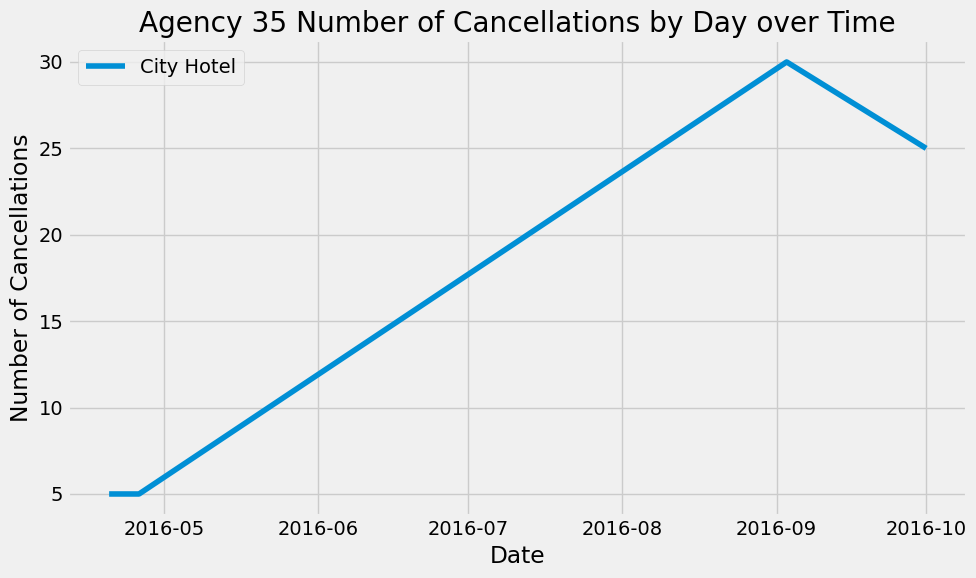

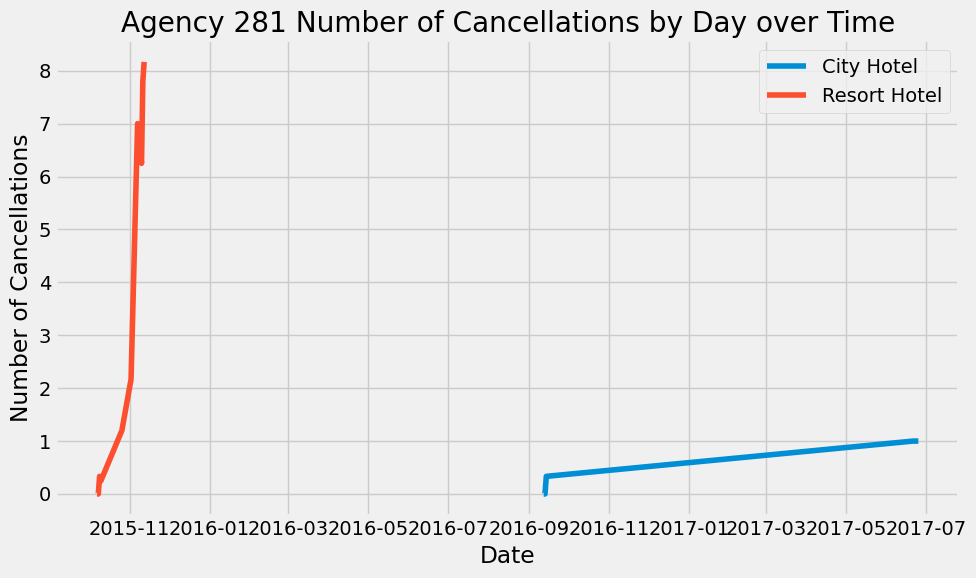

In [28]:
for agency in top_30_agents_by_cancel_numbers.tail(3).index:
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Plot the cancellation rate over time averaged over a 4 week window
    agency_df = df[df['agent'] == agency]
    for hotel in sorted(agency_df['hotel'].unique()):
        ax.plot(agency_df[agency_df['hotel'] == hotel].groupby('date')['is_canceled'].sum().rolling(window=pd.Timedelta(4, 'w')).mean(), label=hotel)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cancellations')
    ax.legend()
    plt.title(f'Agency {int(agency)} Number of Cancellations by Day over Time')
    fig.tight_layout()
    fig.savefig(f'plots/agency_{int(agency)}_cancel_number_over_time.png')
    plt.show()

There doesn't seem to be nearly as clear of a pattern in these agencies. The increase in cancellations is likely primarily due to the top few booking agencies

# Model Training

We are developing a classification model targeting the `is_canceled` field. We will be deploying the quarter following the last observation in the dataset. Considering the temporal nature of the dataset, we will split the dataset so that the final 12 weeks of bookings will be the test dataset, and the remaining data will be the train dataset, as opposed to a random split. This will give us confidence that the model can detect and predict off of future patterns.

In [29]:
max_date = df['date'].max()
test_date_cutoff = max_date - pd.Timedelta(12, 'w')

In [30]:
test_date_cutoff

Timestamp('2017-06-08 00:00:00')

In [31]:
df.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_people,total_nights,date,room_different_from_booking
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2.0,0,2015-07-01,0


In [98]:
numeric_input_cols = [
    'arrival_date_year',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'room_different_from_booking',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests',
]

categorical_input_cols = [
    'hotel',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',  # although agent and company are numerical, it doesn't make sense to treat them as ordinal, so we should encode them.
    'company',
    'customer_type',
]

input_cols = numeric_input_cols + categorical_input_cols
target_col = 'is_canceled'

In [99]:
train_test_separator = df['date'] <= test_date_cutoff

X_train = df[train_test_separator == 1][input_cols]
y_train = df[train_test_separator == 1][target_col]
X_test = df[train_test_separator == 0][input_cols]
y_test = df[train_test_separator == 0][target_col]

In [85]:
X_train.shape

(105153, 18)

In [86]:
y_train.shape

(105153,)

## Logistic Regression

Considering this is a classification problem, the most trivial model we could train would be logistic regression. We will do so as a baseline before trying a more powerful model.

In [172]:
lm = LogisticRegression()
imputer = SimpleImputer(strategy='constant', fill_value=0)
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [173]:
# Method for handling encoding categorical features alongside numeric features obtained from https://stackoverflow.com/a/48355609

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

lm_pipeline = Pipeline([
    ('feature_handling', FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric_input_cols), imputer, scaler)),
        ('categorical', make_pipeline(Columns(names=categorical_input_cols), encoder)),
    ])),
    ('model', GridSearchCV(
        lm,
        param_grid={
            'C': [0.001, 0.01, 0.05, 0.1, 0.5],
            'solver': ['lbfgs',],
            'max_iter': [1000,]
        },
        verbose=3,
    )),
])

In [174]:
lm_pipeline

Pipeline(steps=[('feature_handling',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['arrival_date_year',
                                                                                 'arrival_date_week_number',
                                                                                 'arrival_date_day_of_month',
                                                                                 'lead_time',
                                                                                 'stays_in_weekend_nights',
                                                                                 'stays_in_week_nights',
                                                                                 'adults',
                                                                                 'children',
                                                                                 'babies',
                                                                                 'is_repeated_guest',
                                                                                 'previous_cancellations',
                                                                                 'previous_bookings_n...
                                                                                 'country',
                                                                                 'market_segment',
                                                                                 'distribution_channel',
                                                                                 'reserved_room_type',
                                                                                 'assigned_room_type',
                                                                                 'deposit_type',
                                                                                 'agent',
                                                                                 'company',
                                                                                 'customer_type'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.5],
                                          'max_iter': [1000],
                                          'solver': ['lbfgs']},
                              verbose=3))])

In [175]:
lm_pipeline.fit(X_train, y_train).score(X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.001, max_iter=1000, solver=lbfgs;, score=0.858 total time=   0.2s
[CV 2/5] END C=0.001, max_iter=1000, solver=lbfgs;, score=0.812 total time=   0.1s
[CV 3/5] END C=0.001, max_iter=1000, solver=lbfgs;, score=0.807 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=1000, solver=lbfgs;, score=0.792 total time=   0.1s
[CV 5/5] END C=0.001, max_iter=1000, solver=lbfgs;, score=0.826 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=1000, solver=lbfgs;, score=0.858 total time=   0.3s
[CV 2/5] END C=0.01, max_iter=1000, solver=lbfgs;, score=0.812 total time=   0.3s
[CV 3/5] END C=0.01, max_iter=1000, solver=lbfgs;, score=0.814 total time=   0.3s
[CV 4/5] END C=0.01, max_iter=1000, solver=lbfgs;, score=0.805 total time=   0.3s
[CV 5/5] END C=0.01, max_iter=1000, solver=lbfgs;, score=0.826 total time=   0.3s
[CV 1/5] END C=0.05, max_iter=1000, solver=lbfgs;, score=0.859 total time=   0.4s
[CV 2/5] END C=0.05, max_iter=100

0.7687715108520053

In [176]:
lm_pipeline

Pipeline(steps=[('feature_handling',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['arrival_date_year',
                                                                                 'arrival_date_week_number',
                                                                                 'arrival_date_day_of_month',
                                                                                 'lead_time',
                                                                                 'stays_in_weekend_nights',
                                                                                 'stays_in_week_nights',
                                                                                 'adults',
                                                                                 'children',
                                                                                 'babies',
                                                                                 'is_repeated_guest',
                                                                                 'previous_cancellations',
                                                                                 'previous_bookings_n...
                                                                                 'country',
                                                                                 'market_segment',
                                                                                 'distribution_channel',
                                                                                 'reserved_room_type',
                                                                                 'assigned_room_type',
                                                                                 'deposit_type',
                                                                                 'agent',
                                                                                 'company',
                                                                                 'customer_type'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.5],
                                          'max_iter': [1000],
                                          'solver': ['lbfgs']},
                              verbose=3))])

In [177]:
with open('models/logistic_regression.pkl', 'wb') as fp:
    pickle.dump(lm_pipeline, fp)

In [178]:
df['logistic_regression_model'] = lm_pipeline.predict(df).astype(int)

## XGBoost

After using quick and dirty logistic regression as a baseline, we will test a stronger XGBoost model. We can take the same pipeline, including the preprocessing steps, and switch out the weaker logistic regression model for the stronger XGBoost classifier. Note that XGBoost by itself is powerful and can handle much of the preprocessing we set up the pipeline for, but we'll simply switch it out for the sklearn model for simplicity. We will not train more complex deep learning models, as there is a time constraint on developing a solution, however neural networks could be considered in the future if a more powerful model was needed for improved performance.

In [184]:
xgb_model = xgb.XGBClassifier()
imputer = SimpleImputer(strategy='constant', fill_value=0)
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [185]:
# Method for handling encoding categorical features alongside numeric features obtained from https://stackoverflow.com/a/48355609

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

xgb_pipeline = Pipeline([
    ('feature_handling', FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric_input_cols), imputer, scaler)),
        ('categorical', make_pipeline(Columns(names=categorical_input_cols), encoder)),
    ])),
    ('model', GridSearchCV(
        xgb_model,
        param_grid={
            # I tried out some hyperparameter tuning, but it ended up reducing performance on the test set, so the model was generalizing worse.
        },
        verbose=3,
    )),
])

In [186]:
xgb_pipeline

Pipeline(steps=[('feature_handling',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['arrival_date_year',
                                                                                 'arrival_date_week_number',
                                                                                 'arrival_date_day_of_month',
                                                                                 'lead_time',
                                                                                 'stays_in_weekend_nights',
                                                                                 'stays_in_week_nights',
                                                                                 'adults',
                                                                                 'children',
                                                                                 'babies',
                                                                                 'is_repeated_guest',
                                                                                 'previous_cancellations',
                                                                                 'previous_bookings_n...
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={}, verbose=3))])

In [187]:
xgb_pipeline.fit(X_train, y_train).score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.836 total time=   0.2s
[CV 2/5] END ..................................., score=0.798 total time=   0.3s
[CV 3/5] END ..................................., score=0.834 total time=   0.3s
[CV 4/5] END ..................................., score=0.740 total time=   0.3s
[CV 5/5] END ..................................., score=0.671 total time=   0.2s


0.8031186345437943

In [188]:
with open('models/xgb_classifier.pkl', 'wb') as fp:
    pickle.dump(xgb_pipeline, fp)

In [189]:
df['xgboost_model'] = xgb_pipeline.predict(df).astype(int)

# Results

In [192]:
df['logistic_model_correct'] = (df['logistic_regression_model'] == df['is_canceled']).astype(int)
df['xgboost_model_correct'] = (df['xgboost_model'] == df['is_canceled']).astype(int)

In [197]:
df['date']

0        2015-07-01
75559    2015-07-01
75560    2015-07-01
75561    2015-07-01
75562    2015-07-01
            ...    
40039    2017-08-31
40040    2017-08-31
13794    2017-08-31
40038    2017-08-31
117424   2017-08-31
Name: date, Length: 119390, dtype: datetime64[ns]

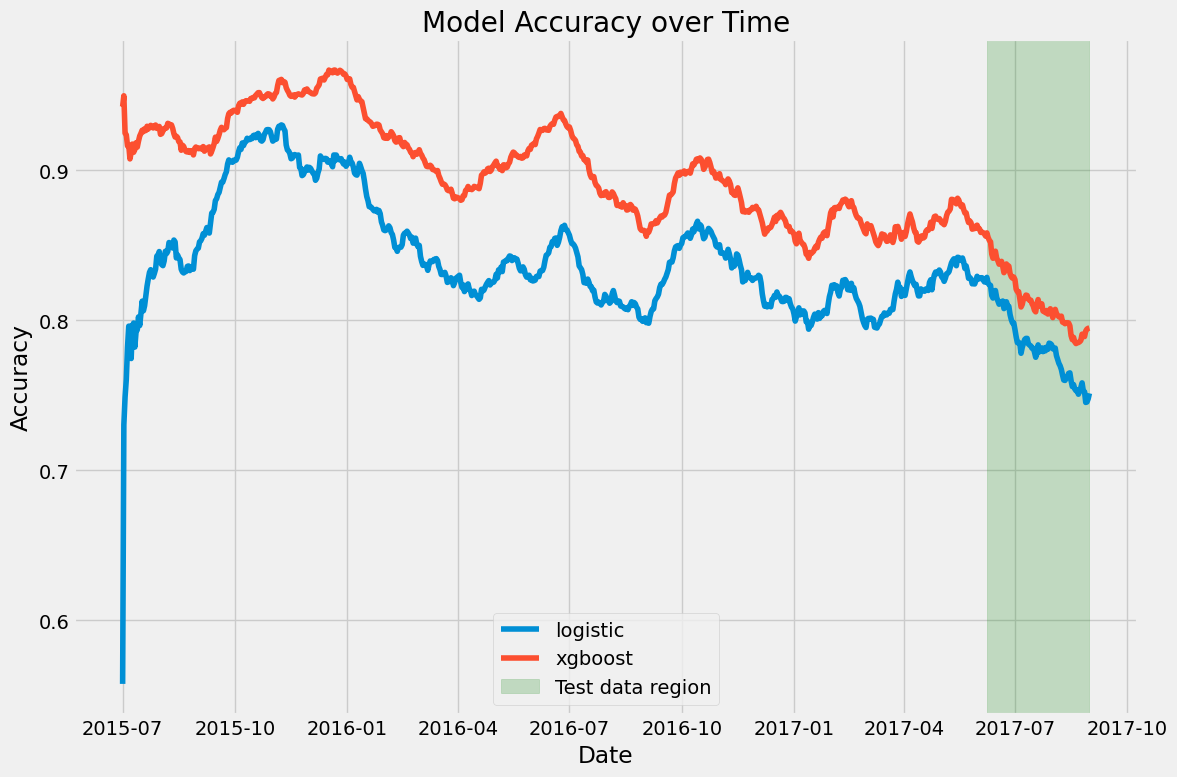

In [215]:
fig, ax = plt.subplots(figsize=(12,8))

for model in ['logistic', 'xgboost']:
    ax.plot(df.groupby('date')[f'{model}_model_correct'].mean().rolling(window=pd.Timedelta(4, 'w')).mean(), label=model)
ax.axvspan(test_date_cutoff, df['date'].max(), alpha=0.2, color='g', label='Test data region')
ax.set_xlabel('Date')
ax.set_ylabel('Accuracy')
plt.title('Model Accuracy over Time')
plt.legend()
plt.tight_layout()
fig.savefig('plots/model_accuracy.png')
plt.show()